<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-ввод" data-toc-modified-id="Общий-ввод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий ввод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.

**Цель исследования:** разработать систему предсказания количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Исходные данные:** исторические данные о заказах такси в аэропортах

Количество заказов находится в столбце `num_orders` 

**Задачи исследования:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
#импортируем необходимые библиотеки:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor 

In [2]:
#Откроем таблицу с данными:

try:
    data = pd.read_csv('C:\\Users\\vasil\\Downloads\\Vremennye_ryady\\taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
display(data.index.is_monotonic)
display(data)

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data= data.resample('1H').sum()

**Вывод:** Представлены данные о заказах такси с 1 марта по 31 августа 2018 года, дата и время заказа были перенесы в индекс, столбец с количеством заказов имеет 26496 строк, пропусков не обнаружено. 

## Анализ

In [5]:
data.index.max() - data.index.min()

Timedelta('183 days 23:00:00')

<AxesSubplot:xlabel='datetime'>

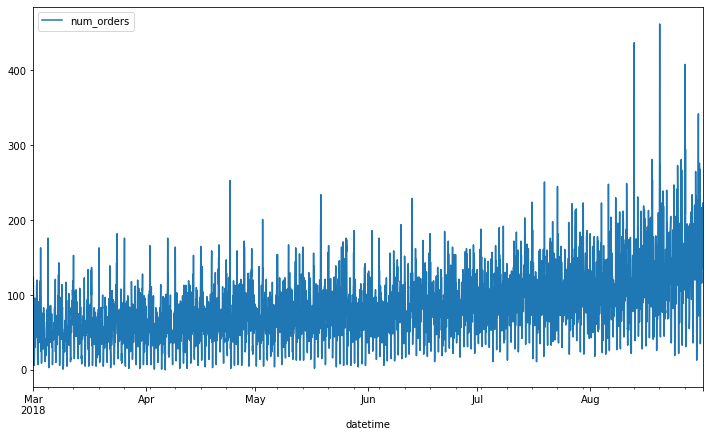

In [6]:
data.plot(ax=plt.gca(),figsize=(12,7))

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='datetime'>

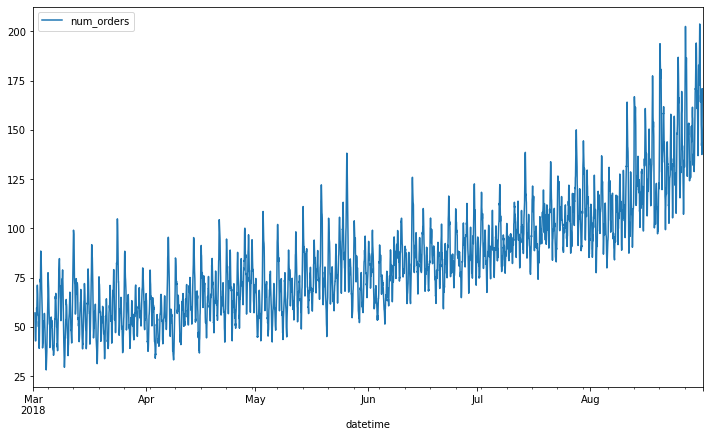

In [8]:
#построим график со скользящим средним, размер окна 12 

data.rolling(12).mean().plot(ax=plt.gca(),figsize=(12,7))

Среднее количество заказов по часам за 183 дня составляет 14 заказов такси, медиана немного меньше (13 заказов), стандарное отклонение 7.5, максимальное значение 77 заказов час. На графике наблюдаются выбивающиеся значения, особенно много их начиная с середины августа. Так же можно заметить возрастающий тренд. Для представления тренда и сезоннности построим графики ниже. 

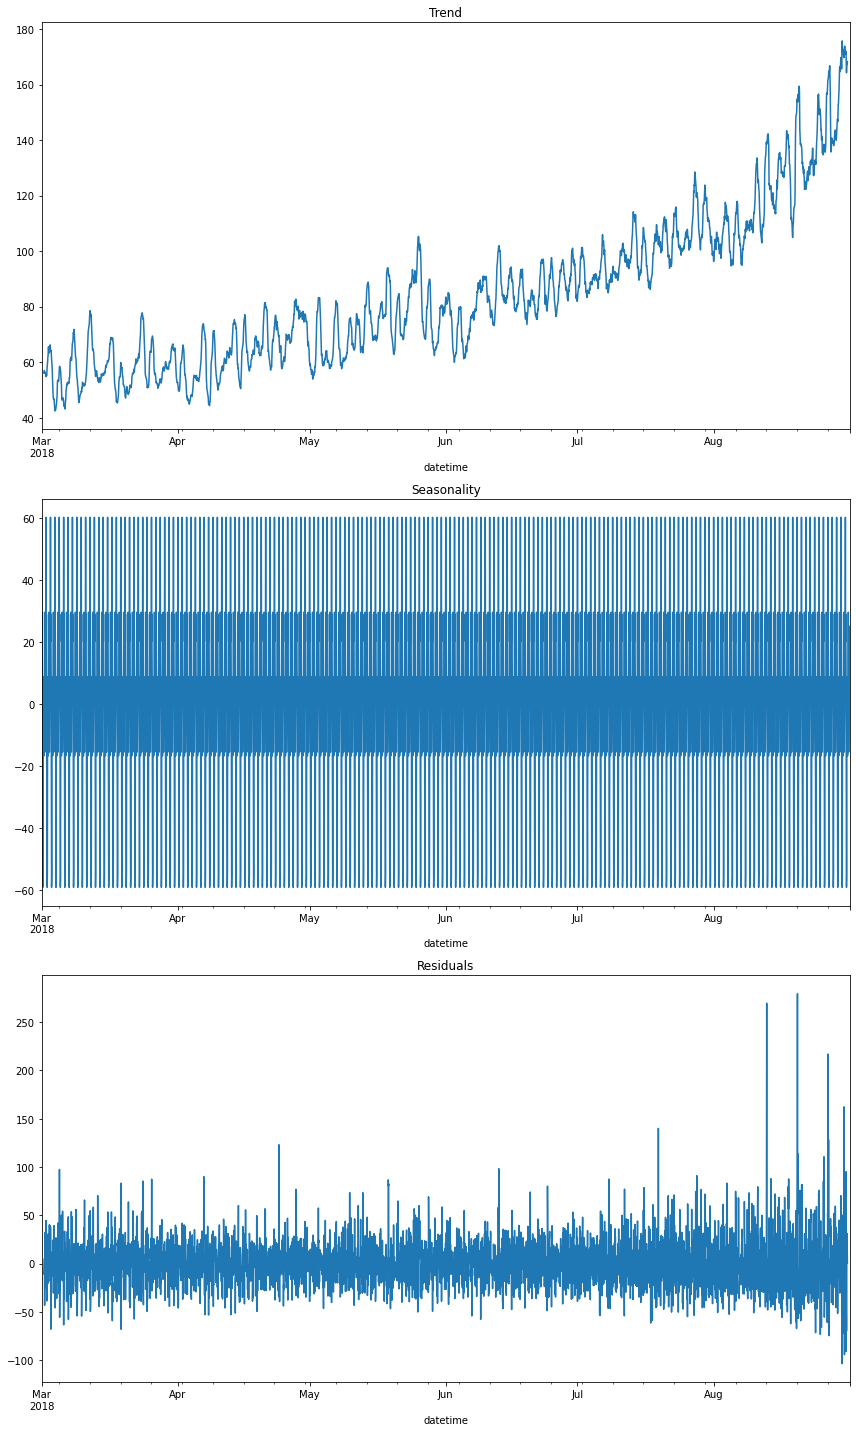

In [9]:
decomposed =  seasonal_decompose(data) 

plt.figure(figsize=(12,20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

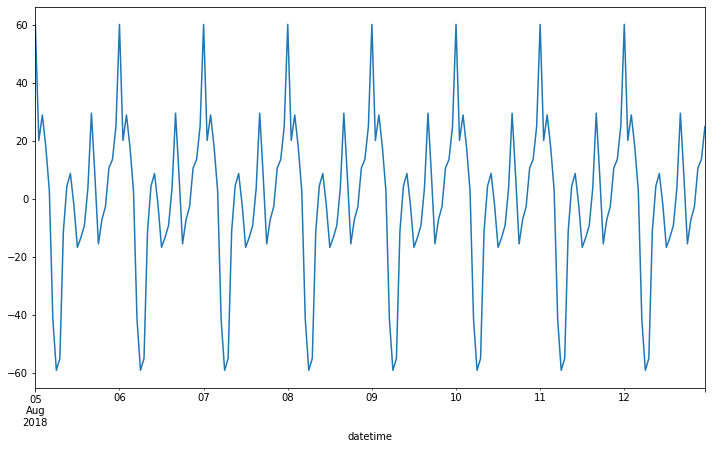

In [10]:
#постороим график сезонности за 1 неделю авгутса 
decomposed.seasonal['2018-08-05':'2018-08-12'].plot(ax=plt.gca(),figsize=(12,7)) 

<AxesSubplot:xlabel='datetime'>

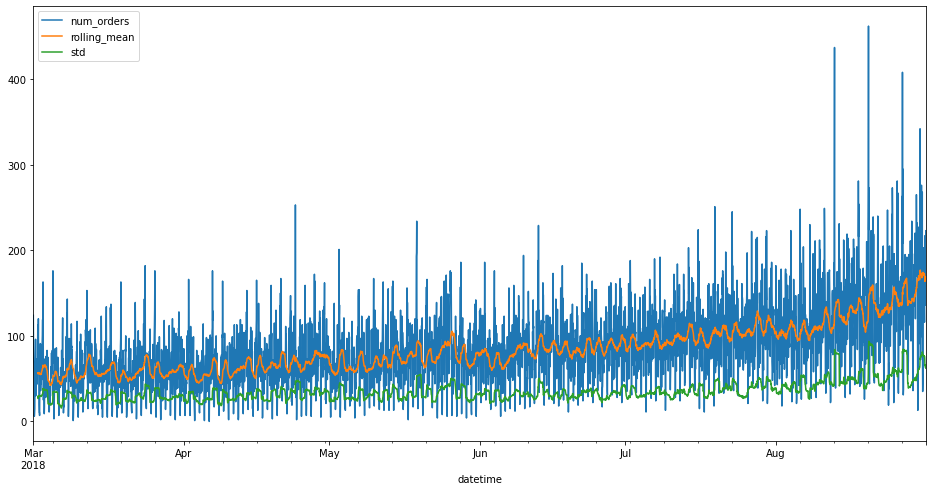

In [11]:
#Построим график скользящего стандарного отклонения 

data_rolling_std = data.copy()
data_rolling_std['rolling_mean'] = data_rolling_std.rolling(24).mean()
data_rolling_std['std'] = data_rolling_std['num_orders'].rolling(24).std()
data_rolling_std.plot(figsize=(16,8))

<AxesSubplot:xlabel='datetime'>

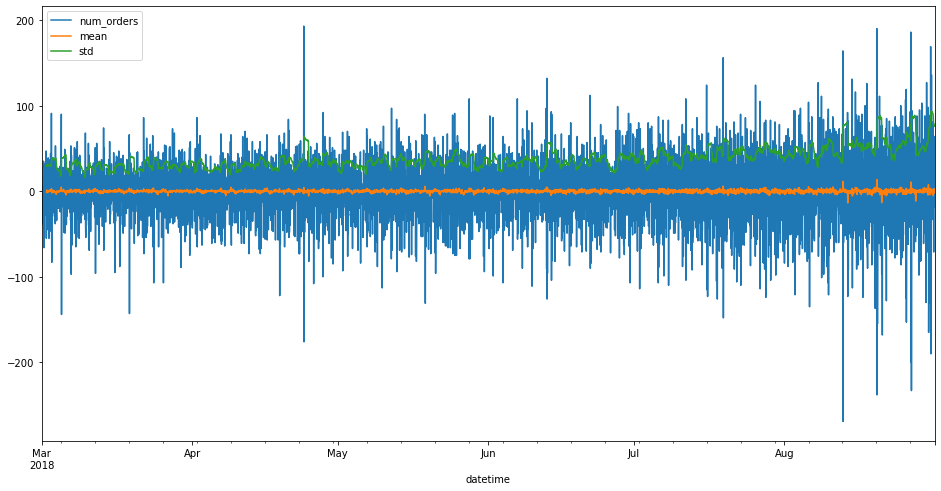

In [12]:
# Найдем разности временного ряда. построим график скользящего среднего стандартного отклонения. 

data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot(figsize=(16, 8))

**Вывод:**

Наблюдается восходящий тренд количества заказов. Начиная с середины лета график показывает увеличение темпа роста. 

Сезонность проявляется в течение суток, в середине ночи и ранним утром количество заказов наименьшее, пиковые значения приходятся на вечер вплоть до 12 часов ночи. 

В августе остатки наиболее шумные, много выбивающихся значений, но и присутствуют редкие низкие значения. 


## Обучение

Создадим признаки и подготовим выборки для обучения моделей:
    

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [14]:
make_features(data,6,24)
data= data.dropna()
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,56.958333


In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
#Функция для расчета RMSE 
def rmse(taget, predict):
    return (mean_squared_error(taget, predict)**0.5)

**Обучим модель линейной регрессии:**

In [18]:
lr = LinearRegression(normalize=True)
lr.fit(features_train, target_train)

LinearRegression(normalize=True)

In [19]:
#создадим метрику оценки для кросс-валидации 
rmse_score = make_scorer(rmse, greater_is_better=False)

In [20]:
cv = TimeSeriesSplit(n_splits=5).split(features_train)

In [21]:
lr_rmse = pd.Series(cross_val_score(lr,features_train,target_train,scoring=rmse_score,cv=cv)).mean()
lr_rmse

-31.7310246292299

**Обучим модель случайного леса:**

In [22]:
cv = TimeSeriesSplit(n_splits=5).split(features_train)

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5,30,5),
                     'max_depth': range(1, 15, 2),
                    }

forest_grid = GridSearchCV(estimator=forest, param_grid=forest_parametrs, scoring=rmse_score, cv=cv)
forest_grid.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001A76C339BA0>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [23]:
#Лучшие параметры
forest_grid.best_params_

{'max_depth': 13, 'n_estimators': 25}

In [24]:
#Качество модели на кросс-валидации 
forest_grid.score(features_train, target_train)

-11.857178468206389

**Oбучим модель градиентного бустинга:**


In [25]:
cv = TimeSeriesSplit(n_splits=5).split(features_train)

cbr = CatBoostRegressor(verbose=100)

cbr_parametrs = {
              'depth': [4, 6, 8],
              'learning_rate': [0.03, 0.1],
                }

cbr_grid = GridSearchCV(estimator=cbr, param_grid=cbr_parametrs, scoring=rmse_score, cv=cv)
cbr_grid.fit(features_train, target_train)

0:	learn: 29.2248405	total: 139ms	remaining: 2m 18s
100:	learn: 18.0739893	total: 193ms	remaining: 1.72s
200:	learn: 16.3010596	total: 246ms	remaining: 976ms
300:	learn: 14.9582558	total: 292ms	remaining: 679ms
400:	learn: 13.9168097	total: 343ms	remaining: 513ms
500:	learn: 12.9825710	total: 392ms	remaining: 390ms
600:	learn: 12.1923781	total: 433ms	remaining: 288ms
700:	learn: 11.4828174	total: 475ms	remaining: 203ms
800:	learn: 10.7787071	total: 516ms	remaining: 128ms
900:	learn: 10.2191994	total: 559ms	remaining: 61.4ms
999:	learn: 9.7378968	total: 603ms	remaining: 0us
0:	learn: 30.0185433	total: 847us	remaining: 847ms
100:	learn: 20.1428455	total: 59.1ms	remaining: 526ms
200:	learn: 18.4991629	total: 110ms	remaining: 439ms
300:	learn: 17.4367345	total: 164ms	remaining: 381ms
400:	learn: 16.6394214	total: 217ms	remaining: 324ms
500:	learn: 15.8550403	total: 285ms	remaining: 283ms
600:	learn: 15.1561757	total: 337ms	remaining: 224ms
700:	learn: 14.5172540	total: 392ms	remaining: 167

300:	learn: 19.1717948	total: 422ms	remaining: 981ms
400:	learn: 18.2948503	total: 555ms	remaining: 829ms
500:	learn: 17.5757285	total: 691ms	remaining: 688ms
600:	learn: 16.9361943	total: 825ms	remaining: 548ms
700:	learn: 16.2622989	total: 964ms	remaining: 411ms
800:	learn: 15.7861739	total: 1.09s	remaining: 271ms
900:	learn: 15.2702655	total: 1.26s	remaining: 138ms
999:	learn: 14.8467578	total: 1.39s	remaining: 0us
0:	learn: 28.1827756	total: 34.2ms	remaining: 34.1s
100:	learn: 11.8535798	total: 196ms	remaining: 1.74s
200:	learn: 8.0454521	total: 292ms	remaining: 1.16s
300:	learn: 5.9140664	total: 384ms	remaining: 891ms
400:	learn: 4.5712574	total: 476ms	remaining: 710ms
500:	learn: 3.5132322	total: 571ms	remaining: 569ms
600:	learn: 2.7644945	total: 671ms	remaining: 446ms
700:	learn: 2.0776967	total: 765ms	remaining: 326ms
800:	learn: 1.5736666	total: 861ms	remaining: 214ms
900:	learn: 1.2210857	total: 956ms	remaining: 105ms
999:	learn: 0.9625211	total: 1.06s	remaining: 0us
0:	lear

700:	learn: 5.3174219	total: 2.37s	remaining: 1.01s
800:	learn: 4.5078817	total: 2.83s	remaining: 703ms
900:	learn: 3.9227907	total: 3.22s	remaining: 354ms
999:	learn: 3.3829574	total: 3.53s	remaining: 0us
0:	learn: 33.0823304	total: 3.69ms	remaining: 3.68s
100:	learn: 17.0698780	total: 361ms	remaining: 3.21s
200:	learn: 14.1599563	total: 657ms	remaining: 2.61s
300:	learn: 11.8808393	total: 952ms	remaining: 2.21s
400:	learn: 10.0731472	total: 1.27s	remaining: 1.91s
500:	learn: 8.6653915	total: 1.6s	remaining: 1.6s
600:	learn: 7.5211978	total: 1.91s	remaining: 1.26s
700:	learn: 6.5367338	total: 2.21s	remaining: 941ms
800:	learn: 5.7440647	total: 2.5s	remaining: 622ms
900:	learn: 5.0519157	total: 2.79s	remaining: 307ms
999:	learn: 4.4796095	total: 3.18s	remaining: 0us
0:	learn: 38.1993168	total: 3.16ms	remaining: 3.16s
100:	learn: 24.0469820	total: 169ms	remaining: 1.5s
200:	learn: 22.3046716	total: 299ms	remaining: 1.19s
300:	learn: 21.0827613	total: 431ms	remaining: 1s
400:	learn: 19.9

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001A76C38EDD0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001A76C36EA60>,
             param_grid={'depth': [4, 6, 8], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [26]:
#Лучшие параметры 
cbr_grid.best_params_

{'depth': 6, 'learning_rate': 0.03}

In [27]:
#Качество модели на кросс-валидации 
cbr_grid.score(features_train, target_train)

-16.2833642421759

**Вывод:** Было обучено три модели, на крос-валидации лучшее качество показала модель случайного леса

## Тестирование

Проверим качество предсказаний модели случайного леса на тестовой выборке:

In [28]:
predict_forest = forest_grid.predict(features_test)

In [29]:
rmse(target_test, predict_forest)

44.6054127971656

**Значение rmse не больше 48, удовляет поставленному условию по качеству предсказаний**

<AxesSubplot:>

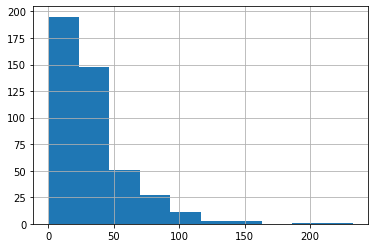

In [30]:
#распределение ошибок предсказания модели случайного леса
error_abs = abs(predict_forest - target_test)
error_abs.hist()

In [31]:
error_abs.describe()

count    440.000000
mean      33.671431
std       29.288687
min        0.170441
25%       13.571335
50%       28.186138
75%       43.765469
max      232.760000
Name: num_orders, dtype: float64

In [32]:
target = pd.Series(target_test)
predict = pd.Series(predict_forest,index=features_test.index)

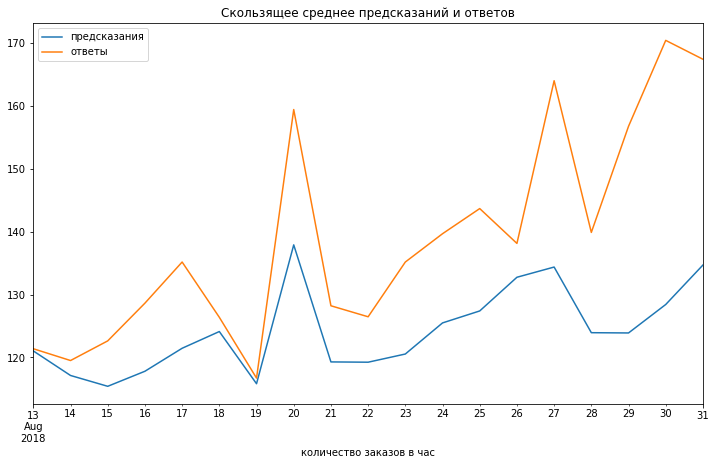

In [33]:
predict.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca(),figsize=(12,7), label='предсказания')
target.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca(),figsize=(12,7), label='ответы')
plt.title("Скользящее среднее предсказаний и ответов")
plt.xlabel("количество заказов в час")
plt.legend(['предсказания', 'ответы'])

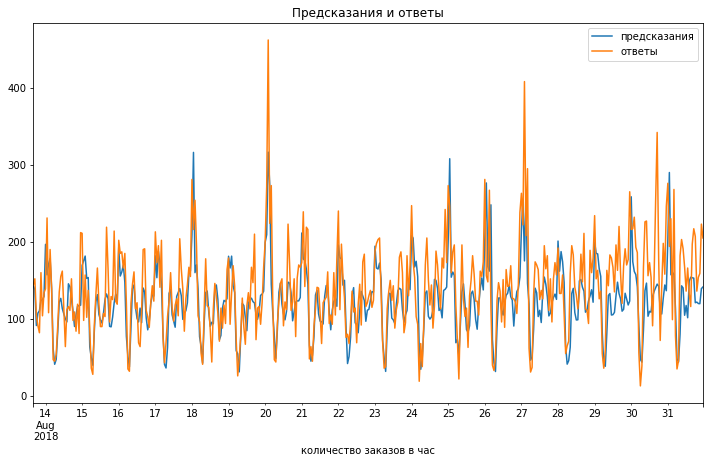

In [34]:
predict.plot(ax=plt.gca(),figsize=(12,7), label='предсказания')
target.plot(ax=plt.gca(),figsize=(12,7), label='ответы')
plt.title("Предсказания и ответы")
plt.xlabel("количество заказов в час")
plt.legend(['предсказания', 'ответы'])

In [35]:
display(predict.describe())
display('_______')
display(target.describe())

count    440.000000
mean     124.356475
std       44.006871
min       31.196524
25%       99.237094
50%      124.797696
75%      143.937785
max      316.440000
dtype: float64

'_______'

count    440.000000
mean     139.561364
std       58.697602
min       13.000000
25%      104.000000
50%      135.000000
75%      173.000000
max      462.000000
Name: num_orders, dtype: float64

## Общий ввод

Для построения предсказательной модели были сделаны следующие шаги:

     данные заргружены и выполнено ресемплирование по одному часу;
     
     проведен анализ данных и выявлен восходящий тренд количества заказов, а также сезонность проявляется в течение суток (в середине ночи и ранним утром количество заказов наименьшее, пиковые значения приходятся на вечер вплоть до 12 часов ночи;
     
    подготовлены признаки (выбрано использвать 6 остающих занчений, окно для скользящего среднего = 24 часа);
    
    обучены 3 модели (линейной регресси, случайного леса, catboost), лучший rmse на кросс-валидации показала модель случайно леса;
    
    модель случайного леса проверена на тестовой выборке, проходит по условию значение rmse. 

**Ошибки предсказний:** Модель чаще всего предсказывает значения близкие средним. Значительно ошибается, когда случаются выбивающиеся значения. График предсказаний более сглаженный, не имеет таких больших пиков и спадов, как график фактических значений: минимальное предсказанное значение в 2.3 раза меньше, чем фактическое; максимальное предсказанное  в 1.6 раз меньше фактического.